# Hand poses reprojection
Step one find the camera matrix and distortion coefficients.
Step two load images anf corresponding hand poses.
Step three project the hand poses to the image plane.


In [1]:
import torch
import torch.utils
import glob
import numpy as np
import natsort
import cv2 
import matplotlib.pyplot as plt
from numpy.typing import NDArray
import sys
import os
from seq_loader import ValData, TrainData
import pandas as pd
from PIL import Image

fx = 636.6593017578125 
fy = 636.251953125
u_0 = 635.283881879317
v_0 = 366.8740353496978



Alternative data loader based on the original txt file of h20 and the adresses

In [2]:

class TrainDataLoader(torch.utils.data.DataLoader):
    def __init__(self, dir):
        self.dir = dir
        self.frames_paths = natsort.natsorted(glob.glob(f"{dir}framesequences_train/*npy"))
        self.label_list = np.loadtxt(f"{dir}action_labels_train.txt")
        # self.obj_list = np.loadtxt(f"{dir}pose_train.txt")

    def __len__(self):
        return len(self.frames_paths)
    
    def __getitem__(self, idx):
        frames_path = self.frames_paths[idx]
        frames = np.load(frames_path)
        frames = torch.from_numpy(frames).float()
        label = int(self.label_list[idx])
        return frames, label


In [3]:
#convert the action labes adresses to lists 

df : pd.DataFrame = pd.read_csv("/Users/dennisbaumann/3d_vision/data/Dataset/action_val.txt", delimiter=" ")
ids: list[int] = df["id"].to_list()
paths: list[str] = df["path"].to_list()
labels: list[int] = df["action_label"].to_list()
start_acts: list[int] = df["start_act"].to_list()
end_acts: list[int] = df["end_act"].to_list()
start_frames: list[int] = df["start_frame"].to_list()
end_frames: list[int] = df["end_frame"].to_list()

action_labels = np.array(labels)
np.save("/Users/dennisbaumann/3d_vision/data/action_labels_val.npy", action_labels)

In [3]:
intrinsics = np.array([[fx, 0, u_0], [0, fy, v_0], [0, 0, 1]])

In [2]:
def project_points(points_3d, intrinsics):
    # Points_3D should be a Nx4 numpy array (N points, homogeneous coordinates)
    projected = np.dot(intrinsics, points_3d.T)  # Project points
    # Normalize by the third row
    projected[:2] /= projected[2]
    return projected[:2].T  # Return only x, y coordinates


In [4]:
def get_poses(path: str, start_act: int, end_act: int, num_frames: int, base_path) -> NDArray:
    
    sequence_len: int = end_act - start_act
    sample_interval: int = int(sequence_len/(num_frames-1))
    current_frame: int = start_act
    frames_idx: list[int] = []
    frames_list = np.linspace(start_act, end_act, num_frames)
    frames_list = frames_list.astype(int)
    print(frames_list)

    print("start_act: ", start_act, "end_act: ", end_act, "sample", sample_interval)
    for i in range(num_frames): 
        frames_idx.append(current_frame)
        current_frame += sample_interval
    #print(frames_idx)
    obj_poses= []
    hand_poses = []
    for i in range(num_frames):
        img_id: str = f"{frames_list[i]}"
        img_id = img_id.zfill(6)
        hand_path = f"{base_path}{path}/cam4/hand_pose/{img_id}.txt"
        obj_path = f"{base_path}{path}/cam4/obj_pose/{img_id}.txt"
        obj_poses.append(np.loadtxt(obj_path))
        hand_pose = np.loadtxt(hand_path)
        hand_poses.append(hand_pose)
        
    return hand_poses, obj_poses

In [5]:
def get_vertices(right, left):
    right_vertices = {}
    left_vertices = {}
    anchor_r = right[0]
    anchor_l = left[0]
    right_vertices["thumb"] = [anchor_r] + right[1:5]
    right_vertices["index"] = [anchor_r ]+ right[5:9]
    right_vertices["middle"] = [anchor_r] + right[9:13]
    right_vertices["ring"] = [anchor_r] + right[13:17]
    right_vertices["pinky"] = [anchor_r] + right[17:21]
    left_vertices["thumb"] = [anchor_l] + left[1:5]
    left_vertices["index"] = [anchor_l] + left[5:9]
    left_vertices["middle"] = [anchor_l] + left[9:13]
    left_vertices["ring"] = [anchor_l] + left[13:17]
    left_vertices["pinky"] = [anchor_l] + left[17:21]
    return right_vertices, left_vertices    


In [8]:
def plotter(train_loader, intrinsics):
    images, labels = next(iter(train_loader))

    for n in range(len(images)):
        image = images[n].numpy()

        # If the image has 3 channels, transpose it from (Channels, Height, Width) to (Height, Width, Channels)
        if image.shape[0] == 3:
            image = image.transpose((1, 2, 0))

        # Display the image
        image = image.astype(int)
        # n =9
        n_frames = 32
        hand_poses, obj_pose = get_poses(paths[n], start_acts[n], end_acts[n], n_frames, "/Users/dennisbaumann/3d_vision/data/")
        print(np.shape(obj_pose))
        print(np.shape(hand_poses))
    

        fig, axs = plt.subplots(8, 4, figsize=(16, 32))

        for j in range(32):
            img = image[j]
            img = img.astype('uint8')
            img = Image.fromarray(img)
            resized_img = img.resize((1280, 720))
            target_im = np.array(resized_img)
            obj_p = obj_pose[j]
            hand_p = hand_poses[j]
            left_hand = hand_p[1:64]
            right_hand = hand_p[65:128]
            left_hand = np.reshape(left_hand, (21,3))
            right_hand = np.reshape(right_hand, (21,3))
            
            obj_p = np.delete(obj_p, 0)
            obj_p = np.reshape(obj_p, (21,3))
            left_ip = []
            right_ip = []
            for i in range(9):
                p3d = obj_p[i]
                p = project_points(p3d, intrinsics)
                u, v = int(p[0]), int(p[1])
                cv2.circle(target_im, (u, v), 5, (0, 0, 255), -1)
            for i in range(21):
                p3l = left_hand[i]
                pl = project_points(p3l, intrinsics)
                ul, vl = int(pl[0]), int(pl[1])
                left_ip.append([ul, vl])
                cv2.circle(target_im, (ul, vl), 5, (0, 255, 0), -1)
                p3r = right_hand[i]
                pr = project_points(p3r, intrinsics)
                ur, vr = int(pr[0]), int(pr[1])
                right_ip.append([ur, vr])
                cv2.circle(target_im, (ur, vr), 5, (255, 0, 0), -1)
            right_vertices , left_vertices = get_vertices(right_ip, left_ip)
            for key in right_vertices.keys():
                        # Plot lines between the vertices
                for i in range(len(right_vertices[key])-1):
                    cv2.line(target_im, tuple(right_vertices[key][i]), tuple(right_vertices[key][i+1]), (255, 0, 0), 2)
                for i in range(len(left_vertices[key])-1):
                    cv2.line(target_im, tuple(left_vertices[key][i]), tuple(left_vertices[key][i+1]), (0, 255, 0), 2)

            axs[j // 4, j % 4].imshow(target_im)
            
            # Save the plot with filename like "0000n.png"
        plt.savefig(f"/Users/dennisbaumann/3d_vision/plots/reproject{str(n).zfill(4)}.png")


In [ ]:
train_dataset = TrainDataLoader("/Users/dennisbaumann/3d_vision/data/Dataset/")
#load and display imaes from the dqtaloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=False)

plotter(train_loader, intrinsics)


In [6]:
def line_plane_intersection(line_point, line_dir, plane_point, plane_normal):
    """ Calculate the intersection of a line with a plane. """
    denom = np.dot(plane_normal, line_dir)
    if np.abs(denom) < 1e-6:
        # Line and plane are parallel
        return None
    d = np.dot(plane_point - line_point, plane_normal) / denom
    intersection = line_point + d * line_dir
    return intersection

def is_point_in_polygon(point, vertices):
    """ Check if a point is inside a polygon defined by vertices on a plane. """
    total_angle = 0
    for i in range(len(vertices)):
        a, b = vertices[i], vertices[(i + 1) % len(vertices)]
        da, db = a - point, b - point
        angle = np.arctan2(np.linalg.norm(np.cross(da, db)), np.dot(da, db))
        total_angle += angle
    return np.isclose(total_angle, 2 * np.pi, atol=1e-5)

In [7]:
def closest_intersection(hand_point, bbox_center, bbox_corners):
    """ Determine closest intersection and its distance from a hand point to the bbox along the line to the center. """
    line_dir = bbox_center - hand_point
    line_dir /= np.linalg.norm(line_dir)  # Normalize the direction vector
    
    # Define bounding box faces using corner indices
    faces = [
        (0, 1, 2, 3), (4, 5, 6, 7), (0, 1, 5, 4), 
        (2, 3, 7, 6), (0, 3, 7, 4), (1, 2, 6, 5)
    ]
    min_distance = np.inf
    closest_point = None
    
    for indices in faces:
        vertices = bbox_corners[list(indices)]
        plane_normal = np.cross(vertices[1] - vertices[0], vertices[2] - vertices[1])
        plane_normal /= np.linalg.norm(plane_normal)  # Normalize
        intersection = line_plane_intersection(hand_point, line_dir, vertices[0], plane_normal)
        if intersection is not None and is_point_in_polygon(intersection, vertices):
            distance = np.linalg.norm(intersection - hand_point)
            if distance < min_distance:
                min_distance = distance
                closest_point = intersection
    
    return min_distance, closest_point

In [14]:
images, labels = next(iter(train_loader))


image = images[0].numpy()

# If the image has 3 channels, transpose it from (Channels, Height, Width) to (Height, Width, Channels)
if image.shape[0] == 3:
    image = image.transpose((1, 2, 0))

# Display the image
image = image.astype(int)
n =0
n_frames = 32
hand_poses, obj_pose = get_poses(paths[n], start_acts[n], end_acts[n], n_frames, "/Users/dennisbaumann/3d_vision/data/")
print(np.shape(obj_pose))
print(np.shape(hand_poses))
img = image[0]
img = img.astype('uint8')
img = Image.fromarray(img)
resized_img = img.resize((1280, 720))
target_im = np.array(resized_img)
obj_p = obj_pose[0]
hand_p = hand_poses[0]
left_hand = hand_p[1:64]
right_hand = hand_p[65:128]
left_hand = np.reshape(left_hand, (21,3))
right_hand = np.reshape(right_hand, (21,3))

obj_p = np.delete(obj_p, 0)
obj_p = np.reshape(obj_p, (21,3))

[ 0  1  3  5  7  9 11 13 15 17 19 21 23 25 27 29 31 33 35 37 39 41 43 45
 47 49 51 53 55 57 59 61]
start_act:  0 end_act:  61 sample 1
(32, 64)
(32, 128)


In [8]:
bbox_corners = np.array([
    obj_p[1], obj_p[2], obj_p[3], obj_p[4],obj_p[5], obj_p[6], obj_p[7], obj_p[8]
])
bbox_center = np.array(obj_p[0])

# Example hand point
hand_point = left_hand[0]
print("Hand point:", hand_point)
print("Bounding box center:", bbox_center)
print("Bounding box corners:", bbox_corners)

# Calculate closest intersection
distance, intersection_point = closest_intersection(hand_point, bbox_center, bbox_corners)
print("Distance:", distance)
print("Intersection point:", intersection_point)
pl = project_points(hand_point, intrinsics)
ul, vl = int(pl[0]), int(pl[1])
cv2.circle(target_im, (ul, vl), 5, (0, 255, 0), -1)
pr = project_points(intersection_point, intrinsics)
ur, vr = int(pr[0]), int(pr[1])
cv2.circle(target_im, (ur, vr), 5, (255, 0, 0), -1)
plt.imshow(target_im)


NameError: name 'obj_p' is not defined

In [8]:
def inverse_and_scale(enc):
        inv_enc = 1 / enc
        inv_enc[inv_enc > 50] = 50
        scaled_enc = inv_enc / np.max(inv_enc)
        return scaled_enc


In [9]:
def get_vertices_encoded( right_enc, left_enc):
    enc_right_vertices = {}
    enc_left_vertices = {}
    right = inverse_and_scale(np.array(right_enc))

    
    left = inverse_and_scale(np.array(left_enc))
    
    anchor_r = right[0]
    anchor_l = left[0]

    enc_right_vertices["thumb"] = np.insert( np.array(right[1:5]),0,anchor_r)
    enc_right_vertices["index"] = np.insert( np.array(right[5:9]),0,anchor_r)
    enc_right_vertices["middle"] = np.insert( np.array(right[9:13]),0,anchor_r)
    enc_right_vertices["ring"] = np.insert( np.array(right[13:17]),0,anchor_r)
    enc_right_vertices["pinky"] = np.insert( np.array(right[17:21]),0,anchor_r)
    enc_left_vertices["thumb"] = np.insert( np.array(left[1:5]),0,anchor_l)
    enc_left_vertices["index"] = np.insert( np.array(left[5:9]),0,anchor_l)
    enc_left_vertices["middle"] = np.insert( np.array(left[9:13]),0,anchor_l)
    enc_left_vertices["ring"] = np.insert( np.array(left[13:17]),0,anchor_l)
    enc_left_vertices["pinky"] = np.insert( np.array(left[17:21]),0,anchor_l)
    
    return enc_right_vertices, enc_left_vertices    
    

In [10]:
def plot_vertices_mask(right_vertices, r_enc, left_vertices, l_enc,n):
    im= np.zeros((720, 1280, 3), np.uint8)
    

    for key in right_vertices.keys():
                        # Plot lines between the vertices
        
        for i in range(len(right_vertices[key])-1):
            print(r_enc[key][i], r_enc[key][i+1])

            r_multi = (r_enc[key][i] + r_enc[key][i+1])/2
            r = int(r_multi*255)
            cv2.line(im, tuple(right_vertices[key][i]), tuple(right_vertices[key][i+1]), (r, r, r), 5)
        for i in range(len(left_vertices[key])-1):
            l_multi = (float(l_enc[key][i]) + float(l_enc[key][i+1]))/2
            l = int(l_multi*255)
            cv2.line(im, tuple(left_vertices[key][i]), tuple(left_vertices[key][i+1]), (l,l,l), 5)
    cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/mask{n}.png", im)

In [11]:
def gaussian_heatmap(image_shape, point, sigma, max_intensity=255):
    """Generate a Gaussian heatmap at a specified point in the image."""
    x, y = np.meshgrid(np.linspace(0, image_shape[1]-1, image_shape[1]),
                       np.linspace(0, image_shape[0]-1, image_shape[0]))
    d = np.sqrt((x - point[0])**2 + (y - point[1])**2)
    g = np.exp(-(d**2 / (2.0 * sigma**2)))
    g /= np.max(g)  # Normalize to max 1.0
    return (g * max_intensity).astype(np.uint8)

In [12]:
def hot_encoding_plotter(train_loader, intrinsics):
    images, labels = next(iter(train_loader))

    for n in range(len(images)):
        image = images[n].numpy()

        # If the image has 3 channels, transpose it from (Channels, Height, Width) to (Height, Width, Channels)
        if image.shape[0] == 3:
            image = image.transpose((1, 2, 0))

        # Display the image
        image = image.astype(int)
        # n =9
        n_frames = 32
        hand_poses, obj_pose = get_poses(paths[n], start_acts[n], end_acts[n], n_frames, "/Users/dennisbaumann/3d_vision/data/")
        print(np.shape(obj_pose))
        print(np.shape(hand_poses))
    

        fig, axs = plt.subplots(8, 4, figsize=(16, 32))

        for j in range(32):
            img = image[j]
            img = img.astype('uint8')
            img = Image.fromarray(img)
            resized_img = img.resize((1280, 720))
            
            target_im = np.array(resized_img)
            target_im= cv2.cvtColor(target_im, cv2.COLOR_BGR2RGB)
            og = np.copy(target_im)
            obj_p = obj_pose[j]
            hand_p = hand_poses[j]
            left_hand = hand_p[1:64]
            right_hand = hand_p[65:128]
            left_hand = np.reshape(left_hand, (21,3))
            right_hand = np.reshape(right_hand, (21,3))
            
            obj_p = np.delete(obj_p, 0)
            obj_p = np.reshape(obj_p, (21,3))
            left_ip = []
            right_ip = []
            left_encodings = []
            right_encodings = []
            bbox_corners = np.array([obj_p[1], obj_p[2], obj_p[3], obj_p[4],obj_p[5], obj_p[6], obj_p[7], obj_p[8]
            ])
            faces = [(0, 1, 2, 3), (4, 5, 6, 7), (0, 1, 5, 4), 
                     (2, 3, 7, 6), (0, 3, 7, 4), (1, 2, 6, 5)]
            
            bbox_center = np.array(obj_p[0])
            heatmaps = np.zeros((720, 1280, 3))
            image_shape = (720, 1280,3)
            print(bbox_corners[0])
            print(bbox_corners[2])
            
            sigma =10
            box_2d = np.array([project_points(p3d, intrinsics) for p3d in bbox_corners])
            lines = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
                    (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
                    (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges

# Draw the lines
            for line in lines:
                cv2.line(target_im, tuple(box_2d[line[0]].astype(int)), tuple(box_2d[line[1]].astype(int)), (0, 255, 0), 2)

            # for i in range(9):
            #     p3d = obj_p[i]
            #     p = project_points(p3d, intrinsics)
            #     u, v = int(p[0]), int(p[1])
            #     cv2.circle(target_im, (u, v), 5, (0, 0, 255), -1)
            for i in range(21):
                p3l = left_hand[i]
                xdistance, intersection_point = closest_intersection(p3l, bbox_center, bbox_corners)
                left_encodings.append(xdistance)
                pl = project_points(p3l, intrinsics)
                ul, vl = int(pl[0]), int(pl[1])
                left_ip.append([ul, vl])
                # if xdistance < 0.02:
                    # cv2.circle(target_im, (ul, vl), 5, (0, 255, 0), -1)
                
                heatmap = gaussian_heatmap(image_shape, (ul,vl), sigma)
                weight = 1/xdistance
                if weight>50:
                    weight = 50
                color_heatmap = cv2.merge([heatmap] * 3)*(weight/50)
                
                heatmaps = cv2.add(heatmaps, color_heatmap)  # Add heatmaps together

                
                p3r = right_hand[i]
                xdistance, intersection_point = closest_intersection(p3r, bbox_center, bbox_corners)
                right_encodings.append(xdistance)
                pr = project_points(p3r, intrinsics)
                ur, vr = int(pr[0]), int(pr[1])
                right_ip.append([ur, vr])
                # if xdistance < 0.02:
                #     cv2.circle(target_im, (ur, vr), 5, (255, 0, 0), -1)
                heatmap = gaussian_heatmap(image_shape, (ur,vr), sigma)
                weight = 1/xdistance
                if weight>50:
                    weight = 50
                color_heatmap = cv2.merge([heatmap] * 3)*(weight/50)
                
                heatmaps = cv2.add(heatmaps, color_heatmap) 
            right_vertices , left_vertices = get_vertices(right_ip, left_ip)
            enc_right_vertices, enc_left_vertices = get_vertices_encoded(right_encodings, left_encodings)
            print(right_vertices)
            print(enc_right_vertices)
            plot_vertices_mask(right_vertices,  enc_right_vertices,left_vertices, enc_left_vertices, j)
            for key in right_vertices.keys():
                        # Plot lines between the vertices
                for i in range(len(right_vertices[key])-1):
                    cv2.line(target_im, tuple(right_vertices[key][i]), tuple(right_vertices[key][i+1]), (255, 0, 0), 2)
                for i in range(len(left_vertices[key])-1):
                    cv2.line(target_im, tuple(left_vertices[key][i]), tuple(left_vertices[key][i+1]), (0, 0, 255), 2)
            print(target_im.dtype)
            heatmaps = heatmaps *255
            og = cv2.cvtColor(og, cv2.COLOR_BGR2RGB)
            blended_image = cv2.addWeighted(target_im, 0.5, heatmaps.astype(np.uint8), 0.5, 0)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/heat/heat{j}.png", heatmaps)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/blend/heatblend{j}.png", blended_image)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/og/og{j}.png", og)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/targets/target{j}.png", target_im)


            axs[j // 4, j % 4].imshow(target_im)
            # Save the plot with filename like "0000n.png"
        plt.savefig(f"/Users/dennisbaumann/3d_vision/plots/reproject{str(n).zfill(4)}.png")


In [12]:
def seq_plotter(train_loader, intrinsics):
    for i, (img, hand_poses, label, obj_poses) in enumerate(train_loader):
        print(np.shape(img))
        if i % 10 == 0:
            img = img[0].numpy()
            tmp = img[:, 0, :, :]
            tmp = np.asarray(tmp, dtype=np.uint8)

            tmp = np.transpose(tmp, (1, 2, 0))
            tmp = Image.fromarray(tmp)
            #tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR)
            resized_img = tmp.resize((1280, 720))
            
            target_im = np.array(resized_img)
            tmp= cv2.cvtColor(target_im, cv2.COLOR_BGR2RGB)
            hand_p = hand_poses[0][0].numpy()
            obj_p = obj_poses[0][0].numpy()
            obj_p = np.delete(obj_p, 0)
            obj_p = np.reshape(obj_p, (21,3))
            left_ip = []
            right_ip = []
            left_encodings = []
            right_encodings = []
            bbox_corners = np.array([obj_p[1], obj_p[2], obj_p[3], obj_p[4],obj_p[5], obj_p[6], obj_p[7], obj_p[8]
            ])
            left_hand = hand_p[1:64]
            right_hand = hand_p[65:128]
            left_hand = np.reshape(left_hand, (21,3))
            right_hand = np.reshape(right_hand, (21,3))
            bbox_center = np.array(obj_p[0])
            heatmaps = np.zeros((720, 1280, 3))
            image_shape = (720, 1280,3)
            print(bbox_corners[0])
            print(bbox_corners[2])
            
            sigma =10
            box_2d = np.array([project_points(p3d, intrinsics) for p3d in bbox_corners])
            lines = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
                    (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
                    (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges
            for line in lines:
                cv2.line(tmp, tuple(box_2d[line[0]].astype(int)), tuple(box_2d[line[1]].astype(int)), (0, 255, 0), 2)

            for j in range(21):
                p3l = left_hand[j]
                xdistance, intersection_point = closest_intersection(p3l, bbox_center, bbox_corners)
                left_encodings.append(xdistance)
                pl = project_points(p3l, intrinsics)
                ul, vl = int(pl[0]), int(pl[1])
                left_ip.append([ul, vl])
                # if xdistance < 0.02:
                    # cv2.circle(target_im, (ul, vl), 5, (0, 255, 0), -1)
                heatmap = gaussian_heatmap(image_shape, (ul,vl), sigma)
                weight = 1/xdistance
                if weight>50:
                    weight = 50
                color_heatmap = cv2.merge([heatmap] * 3)*(weight/50)
                
                heatmaps = cv2.add(heatmaps, color_heatmap)  # Add heatmaps together
                heatmaps = np.clip(heatmaps, 0, 255)
                p3r = right_hand[j]
                xdistance, intersection_point = closest_intersection(p3r, bbox_center, bbox_corners)
                right_encodings.append(xdistance)
                pr = project_points(p3r, intrinsics)
                ur, vr = int(pr[0]), int(pr[1])
                right_ip.append([ur, vr])
                # if xdistance < 0.02:
                #     cv2.circle(target_im, (ur, vr), 5, (255, 0, 0), -1)
                heatmap = gaussian_heatmap(image_shape, (ur,vr), sigma)
                weight = 1/xdistance
                if weight>50:
                    weight = 50
                color_heatmap = cv2.merge([heatmap] * 3)*(weight/50)
                
                heatmaps = cv2.add(heatmaps, color_heatmap) 
                heatmaps = np.clip(heatmaps, 0, 255)
            right_vertices , left_vertices = get_vertices(right_ip, left_ip)
            enc_right_vertices, enc_left_vertices = get_vertices_encoded(right_encodings, left_encodings)
            print(right_vertices)
            print(enc_right_vertices)
            #plot_vertices_mask(right_vertices,  enc_right_vertices,left_vertices, enc_left_vertices, j)
            for key in right_vertices.keys():
                        # Plot lines between the vertices
                for j in range(len(right_vertices[key])-1):
                    cv2.line(tmp, tuple(right_vertices[key][j]), tuple(right_vertices[key][j+1]), (255, 0, 0), 2)
                for j in range(len(left_vertices[key])-1):
                    cv2.line(tmp, tuple(left_vertices[key][j]), tuple(left_vertices[key][j+1]), (0, 0, 255), 2)
            

            # Now you can convert the color
            
            print(np.max(heatmaps))
            save_map = cv2.cvtColor(heatmaps.astype(np.uint8), cv2.COLOR_BGR2GRAY)
            print(np.shape(save_map))
            # save_map = cv2.cvtColor(heatmaps, cv2.COLOR_BGR2GRAY)
            
            blended_image = cv2.addWeighted(tmp, 0.5, heatmaps.astype(np.uint8), 0.5, 0)
            
            cv2.putText(tmp, f"Label: {label}", (10, 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/seq/seq{i}.png", tmp)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/seq/heat{i}.png", save_map)
            cv2.imwrite(f"/Users/dennisbaumann/3d_vision/plots/seq/blend{i}.png", blended_image)

            

In [14]:
def heatmap_saver(train_loader, intrinsics):
    for i, (img, hand_poses, label, obj_poses) in enumerate(train_loader):
        frames : list[NDArray] = []
        #print(np.shape(img))
    
        
        for k in range(len(img[0][1])):

            # print(k,np.shape(img))
            kimg = img[0].numpy()
            tmp = kimg[:, k, :, :]
            tmp = np.asarray(tmp, dtype=np.uint8)

            tmp = np.transpose(tmp, (1, 2, 0))
            tmp = Image.fromarray(tmp)
            #tmp = cv2.cvtColor(tmp, cv2.COLOR_RGB2BGR)
            resized_img = tmp.resize((1280, 720))
            
            target_im = np.array(resized_img)
            tmp= cv2.cvtColor(target_im, cv2.COLOR_BGR2RGB)
            hand_p = hand_poses[0][k].numpy()
            obj_p = obj_poses[0][k].numpy()
            obj_p = np.delete(obj_p, 0)
            obj_p = np.reshape(obj_p, (21,3))
            left_ip = []
            right_ip = []
            left_encodings = []
            right_encodings = []
            bbox_corners = np.array([obj_p[1], obj_p[2], obj_p[3], obj_p[4],obj_p[5], obj_p[6], obj_p[7], obj_p[8]
            ])
            left_hand = hand_p[1:64]
            right_hand = hand_p[65:128]
            left_hand = np.reshape(left_hand, (21,3))
            right_hand = np.reshape(right_hand, (21,3))
            bbox_center = np.array(obj_p[0])
            heatmaps = np.zeros((720, 1280, 3))
            image_shape = (720, 1280,3)
            # print(bbox_corners[0])
            # print(bbox_corners[2])
            
            sigma =10
            box_2d = np.array([project_points(p3d, intrinsics) for p3d in bbox_corners])
            lines = [(0, 1), (1, 2), (2, 3), (3, 0),  # Bottom face
                    (4, 5), (5, 6), (6, 7), (7, 4),  # Top face
                    (0, 4), (1, 5), (2, 6), (3, 7)]  # Vertical edges
            for line in lines:
                cv2.line(tmp, tuple(box_2d[line[0]].astype(int)), tuple(box_2d[line[1]].astype(int)), (0, 255, 0), 2)

            for j in range(21):
                p3l = left_hand[j]
                xdistance, intersection_point = closest_intersection(p3l, bbox_center, bbox_corners)
                left_encodings.append(xdistance)
                pl = project_points(p3l, intrinsics)
                ul, vl = int(pl[0]), int(pl[1])
                left_ip.append([ul, vl])
                # if xdistance < 0.02:
                    # cv2.circle(target_im, (ul, vl), 5, (0, 255, 0), -1)
                heatmap = gaussian_heatmap(image_shape, (ul,vl), sigma)
                weight = 1/xdistance
                if weight>50:
                    weight = 50
                color_heatmap = cv2.merge([heatmap] * 3)*(weight/50)
                
                heatmaps = cv2.add(heatmaps, color_heatmap)  # Add heatmaps together
                heatmaps = np.clip(heatmaps, 0, 255)
                p3r = right_hand[j]
                xdistance, intersection_point = closest_intersection(p3r, bbox_center, bbox_corners)
                right_encodings.append(xdistance)
                pr = project_points(p3r, intrinsics)
                ur, vr = int(pr[0]), int(pr[1])
                right_ip.append([ur, vr])
                # if xdistance < 0.02:
                #     cv2.circle(target_im, (ur, vr), 5, (255, 0, 0), -1)
                heatmap = gaussian_heatmap(image_shape, (ur,vr), sigma)
                weight = 1/xdistance
                if weight>50:
                    weight = 50
                color_heatmap = cv2.merge([heatmap] * 3)*(weight/50)
                
                heatmaps = cv2.add(heatmaps, color_heatmap) 
                heatmaps = np.clip(heatmaps, 0, 255)
            right_vertices , left_vertices = get_vertices(right_ip, left_ip)
            enc_right_vertices, enc_left_vertices = get_vertices_encoded(right_encodings, left_encodings)
            # print(right_vertices)
            # print(enc_right_vertices)
            #plot_vertices_mask(right_vertices,  enc_right_vertices,left_vertices, enc_left_vertices, j)
            for key in right_vertices.keys():
                        # Plot lines between the vertices
                for j in range(len(right_vertices[key])-1):
                    cv2.line(tmp, tuple(right_vertices[key][j]), tuple(right_vertices[key][j+1]), (255, 0, 0), 2)
                for j in range(len(left_vertices[key])-1):
                    cv2.line(tmp, tuple(left_vertices[key][j]), tuple(left_vertices[key][j+1]), (0, 0, 255), 2)
            

            # Now you can convert the color
            

            save_map = cv2.cvtColor(heatmaps.astype(np.uint8), cv2.COLOR_BGR2GRAY)
            frames.append(save_map)
        np.save('/Users/dennisbaumann/3d_vision/data/seq_8_train/heatmaps_train/' + f'{i+1:03d}.npy', frames)
            

In [17]:
def test_map(train_loader):
    for i, (img, hand_poses, label, obj_poses,heatmaps) in enumerate(train_loader):
        print(heatmaps.shape)
        print(img.shape)
        img = img[0].numpy()
        heat = heatmaps[0].numpy()
        tmp = img[:, 0, :, :]
        heat_tmp = heat[0, :, :] 
        tmp = np.asarray(tmp, dtype=np.uint8)
        heat_tmp = np.asarray(heat_tmp, dtype=np.uint8)
        heat_im = Image.fromarray(heat_tmp) 
        heat_im = heat_im.resize((640, 360))
        heat_tmp = np.array(heat_im)
        heat_tmp = cv2.cvtColor(heat_tmp, cv2.COLOR_GRAY2BGR)
        print(np.max(heat_tmp))
        tmp = np.transpose(tmp, (1, 2, 0))
        blend =cv2.addWeighted(tmp, 0.5, heat_tmp, 0.5, 0)
        cv2.imwrite(f"/Users/dennisbaumann/3d_vision/heat_blend{i}.png", blend)

        if i == 0:
            break

In [15]:
train_dataset = TrainData()
#load and display imaes from the dqtaloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)
print(len(train_loader))
#test_map(train_loader)

heatmap_saver(train_loader, intrinsics)



569


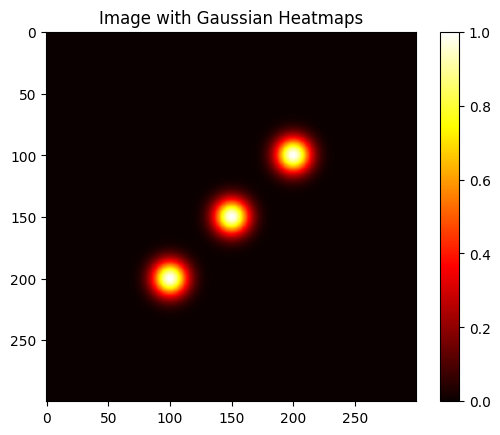

In [264]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Function to create a Gaussian heatmap at a specified location


# Main image setup
image_shape = (300, 300)  # Define the size of your image
image = np.zeros(image_shape)  # Start with an empty image

# Points of interest
points = [(150, 150), (100, 200), (200, 100)]  # List of points (x, y)
sigma = 10  # Standard deviation of the Gaussian

# Apply Gaussian heatmaps to each point
for point in points:
    heatmap = gaussian_heatmap(image_shape, point, sigma)
    image += heatmap  # Add the heatmap to the image

# Normalize the image to [0, 1] for display purposes
image_normalized = image / np.max(image)

# Display the image
plt.imshow(image_normalized, cmap='hot')
plt.colorbar()
plt.title('Image with Gaussian Heatmaps')
plt.show()
